In [192]:
import datetime as dt
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , StratifiedKFold


In [193]:
df = pd.read_csv("bear_attacks.csv" )
df.head()

,Date,Location,Details,Bear,Latitude,Longitude,Name,Age,Gender
0,"August 23, 2018","Lyon Inlet, Nunavut","Three men from Naujaat, whose boat had broken ...",Polar,66.534160,-83.882170,Darryl Kaunak,33,male
1,"July 3, 2018","Sentry Island, Nunavut",A polar bear approached a man and his children...,Polar,61.167230,-93.850150,Aaron Gibbons,31,male
2,"July 9, 1999","near Rankin Inlet, Nunavut",Amitnak was mauled after trying to distract a ...,Polar,62.808913,-92.087741,Hattie Amitnak,64,female
3,"December 8, 1990","Point Lay, Alaska","While Stalker was walking with his girlfriend,...",Polar,69.742800,-163.011250,Carl Stalker,28,male
4,"November 29, 1983","Churchill, Manitoba",Mutanen was attacked and dragged on a street i...,Polar,58.767755,-94.163998,Thomas Mutanen,46,male


In [194]:
dow_categories = ['Monday' , 'Tuesday' , 'Wednesday' , 'Thursday' , 'Friday' , 'Saturday' , 'Sunday']


df.Date = pd.to_datetime(df.Date , format = 'mixed' , errors='coerce')
df['year'] = pd.Categorical(df.Date.dt.year.astype('Int64') , ordered=True)
df['month'] = pd.Categorical(df.Date.dt.month.astype('Int64') ,categories = list(range(1 , 13)) )
df['day_of_month'] = pd.Categorical(df.Date.dt.day.astype('Int64') ,categories = list(range(1 , 32)) )
df['day_of_week'] = pd.Categorical(df.Date.dt.day_name() , categories = dow_categories)

df['Gender'] = pd.Categorical(df['Gender'])
df.head()


,Date,Location,Details,Bear,Latitude,Longitude,Name,Age,Gender,year,month,day_of_month,day_of_week
0,2018-08-23,"Lyon Inlet, Nunavut","Three men from Naujaat, whose boat had broken ...",Polar,66.534160,-83.882170,Darryl Kaunak,33,male,2018,8,23,Thursday
1,2018-07-03,"Sentry Island, Nunavut",A polar bear approached a man and his children...,Polar,61.167230,-93.850150,Aaron Gibbons,31,male,2018,7,3,Tuesday
2,1999-07-09,"near Rankin Inlet, Nunavut",Amitnak was mauled after trying to distract a ...,Polar,62.808913,-92.087741,Hattie Amitnak,64,female,1999,7,9,Friday
3,1990-12-08,"Point Lay, Alaska","While Stalker was walking with his girlfriend,...",Polar,69.742800,-163.011250,Carl Stalker,28,male,1990,12,8,Saturday
4,1983-11-29,"Churchill, Manitoba",Mutanen was attacked and dragged on a street i...,Polar,58.767755,-94.163998,Thomas Mutanen,46,male,1983,11,29,Tuesday


In [195]:
days_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_of_week_order, ordered=True)


In [196]:
def is_fatal(details):

    fatal_keywords = [
    'died', 'killed', 'fatal', 'dead', 'mauled to death', 'succumbed',
    'did not survive', 'passed away', 'pronounced dead', 'lost his life',
    'lost her life', 'slain', 'fatally injured', 'mortally wounded'
    ]
    return any(keyword in details.lower() for keyword in fatal_keywords)


df['Fatal'] = df['Details'].apply(is_fatal).astype(int)
df.head()

,Date,Location,Details,Bear,Latitude,Longitude,Name,Age,Gender,year,month,day_of_month,day_of_week,Fatal
0,2018-08-23,"Lyon Inlet, Nunavut","Three men from Naujaat, whose boat had broken ...",Polar,66.534160,-83.882170,Darryl Kaunak,33,male,2018,8,23,Thursday,1
1,2018-07-03,"Sentry Island, Nunavut",A polar bear approached a man and his children...,Polar,61.167230,-93.850150,Aaron Gibbons,31,male,2018,7,3,Tuesday,1
2,1999-07-09,"near Rankin Inlet, Nunavut",Amitnak was mauled after trying to distract a ...,Polar,62.808913,-92.087741,Hattie Amitnak,64,female,1999,7,9,Friday,0
3,1990-12-08,"Point Lay, Alaska","While Stalker was walking with his girlfriend,...",Polar,69.742800,-163.011250,Carl Stalker,28,male,1990,12,8,Saturday,1
4,1983-11-29,"Churchill, Manitoba",Mutanen was attacked and dragged on a street i...,Polar,58.767755,-94.163998,Thomas Mutanen,46,male,1983,11,29,Tuesday,0


In [197]:
states = [
    'Alabama', 'AL', 'Alaska', 'AK', 'Arizona', 'AZ', 'Arkansas', 'AR', 'California', 'CA', 'Colorado', 'CO',
    'Connecticut', 'CT', 'Delaware', 'DE', 'Florida', 'FL', 'Georgia', 'GA', 'Hawaii', 'HI', 'Idaho', 'ID', 
    'Illinois', 'IL', 'Indiana', 'IN', 'Iowa', 'IA', 'Kansas', 'KS', 'Kentucky', 'KY', 'Louisiana', 'LA', 
    'Maine', 'ME', 'Maryland', 'MD', 'Massachusetts', 'MA', 'Michigan', 'MI', 'Minnesota', 'MN', 'Mississippi', 
    'MS', 'Missouri', 'MO', 'Montana', 'MT', 'Nebraska', 'NE', 'Nevada', 'NV', 'New Hampshire', 'NH', 'New Jersey', 
    'NJ', 'New Mexico', 'NM', 'New York', 'NY', 'North Carolina', 'NC', 'North Dakota', 'ND', 'Ohio', 'OH', 
    'Oklahoma', 'OK', 'Oregon', 'OR', 'Pennsylvania', 'PA', 'Rhode Island', 'RI', 'South Carolina', 'SC', 
    'South Dakota', 'SD', 'Tennessee', 'TN', 'Texas', 'TX', 'Utah', 'UT', 'Vermont', 'VT', 'Virginia', 'VA', 
    'Washington', 'WA', 'West Virginia', 'WV', 'Wisconsin', 'WI', 'Wyoming', 'WY'
]



def extract_state_from_split(location):
    
    location_parts = [part.strip() for part in location.split(',')]
    
    
    for part in location_parts:
        if part in states:
            return part
    return None


df['State'] = df['Location'].apply(extract_state_from_split)
df.head()

,Date,Location,Details,Bear,Latitude,Longitude,Name,Age,Gender,year,month,day_of_month,day_of_week,Fatal,State
0,2018-08-23,"Lyon Inlet, Nunavut","Three men from Naujaat, whose boat had broken ...",Polar,66.534160,-83.882170,Darryl Kaunak,33,male,2018,8,23,Thursday,1,None
1,2018-07-03,"Sentry Island, Nunavut",A polar bear approached a man and his children...,Polar,61.167230,-93.850150,Aaron Gibbons,31,male,2018,7,3,Tuesday,1,None
2,1999-07-09,"near Rankin Inlet, Nunavut",Amitnak was mauled after trying to distract a ...,Polar,62.808913,-92.087741,Hattie Amitnak,64,female,1999,7,9,Friday,0,None
3,1990-12-08,"Point Lay, Alaska","While Stalker was walking with his girlfriend,...",Polar,69.742800,-163.011250,Carl Stalker,28,male,1990,12,8,Saturday,1,Alaska
4,1983-11-29,"Churchill, Manitoba",Mutanen was attacked and dragged on a street i...,Polar,58.767755,-94.163998,Thomas Mutanen,46,male,1983,11,29,Tuesday,0,None


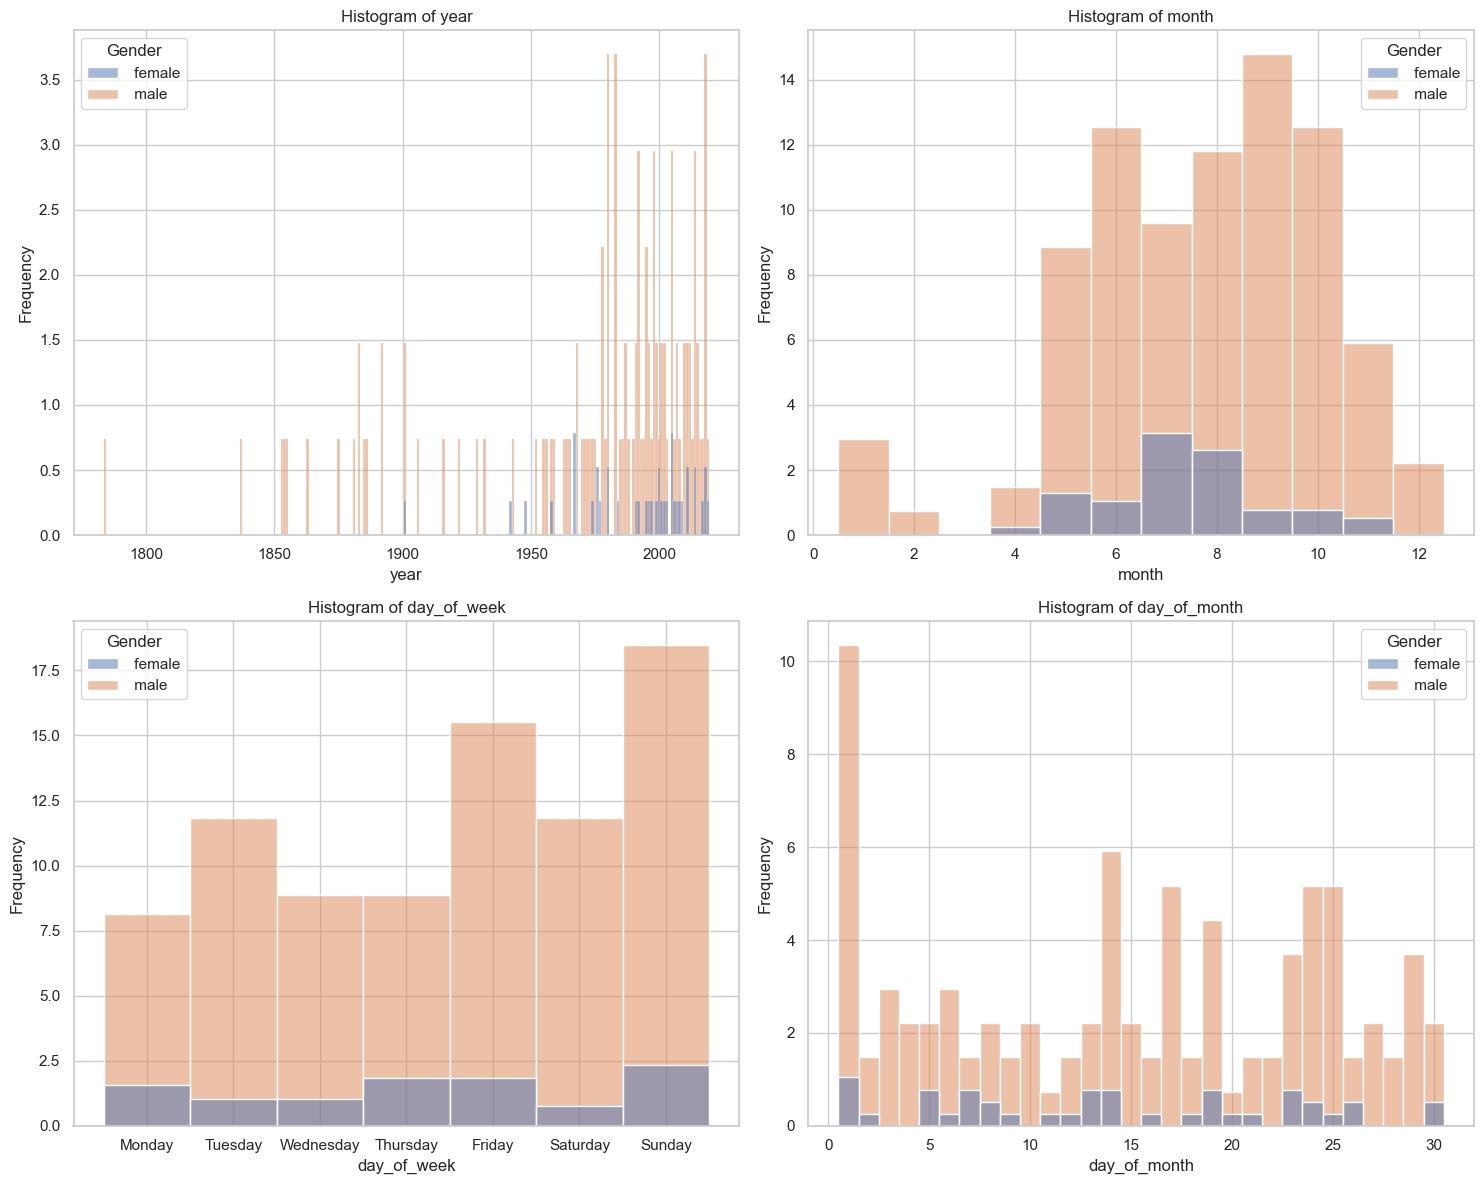

In [198]:

sns.set(style="whitegrid")

columns_to_plot = ["year" , "month" , "day_of_week" , "day_of_month"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))


axes = axes.flatten()


for i, column in enumerate(columns_to_plot):
    sns.histplot(x=column , data=df , ax=axes[i] ,  discrete = True , hue = 'Gender' , stat = "frequency")
    axes[i].set_title(f"Histogram of {column}")


plt.tight_layout()
plt.show()

C:\Users\luisd\AppData\Local\Temp\ipykernel_55932\2115379102.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x='Fatal' , data=df , ax=axes[i] , hue = column )
C:\Users\luisd\AppData\Local\Temp\ipykernel_55932\2115379102.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x='Fatal' , data=df , ax=axes[i] , hue = column )


<Figure size 640x480 with 0 Axes>

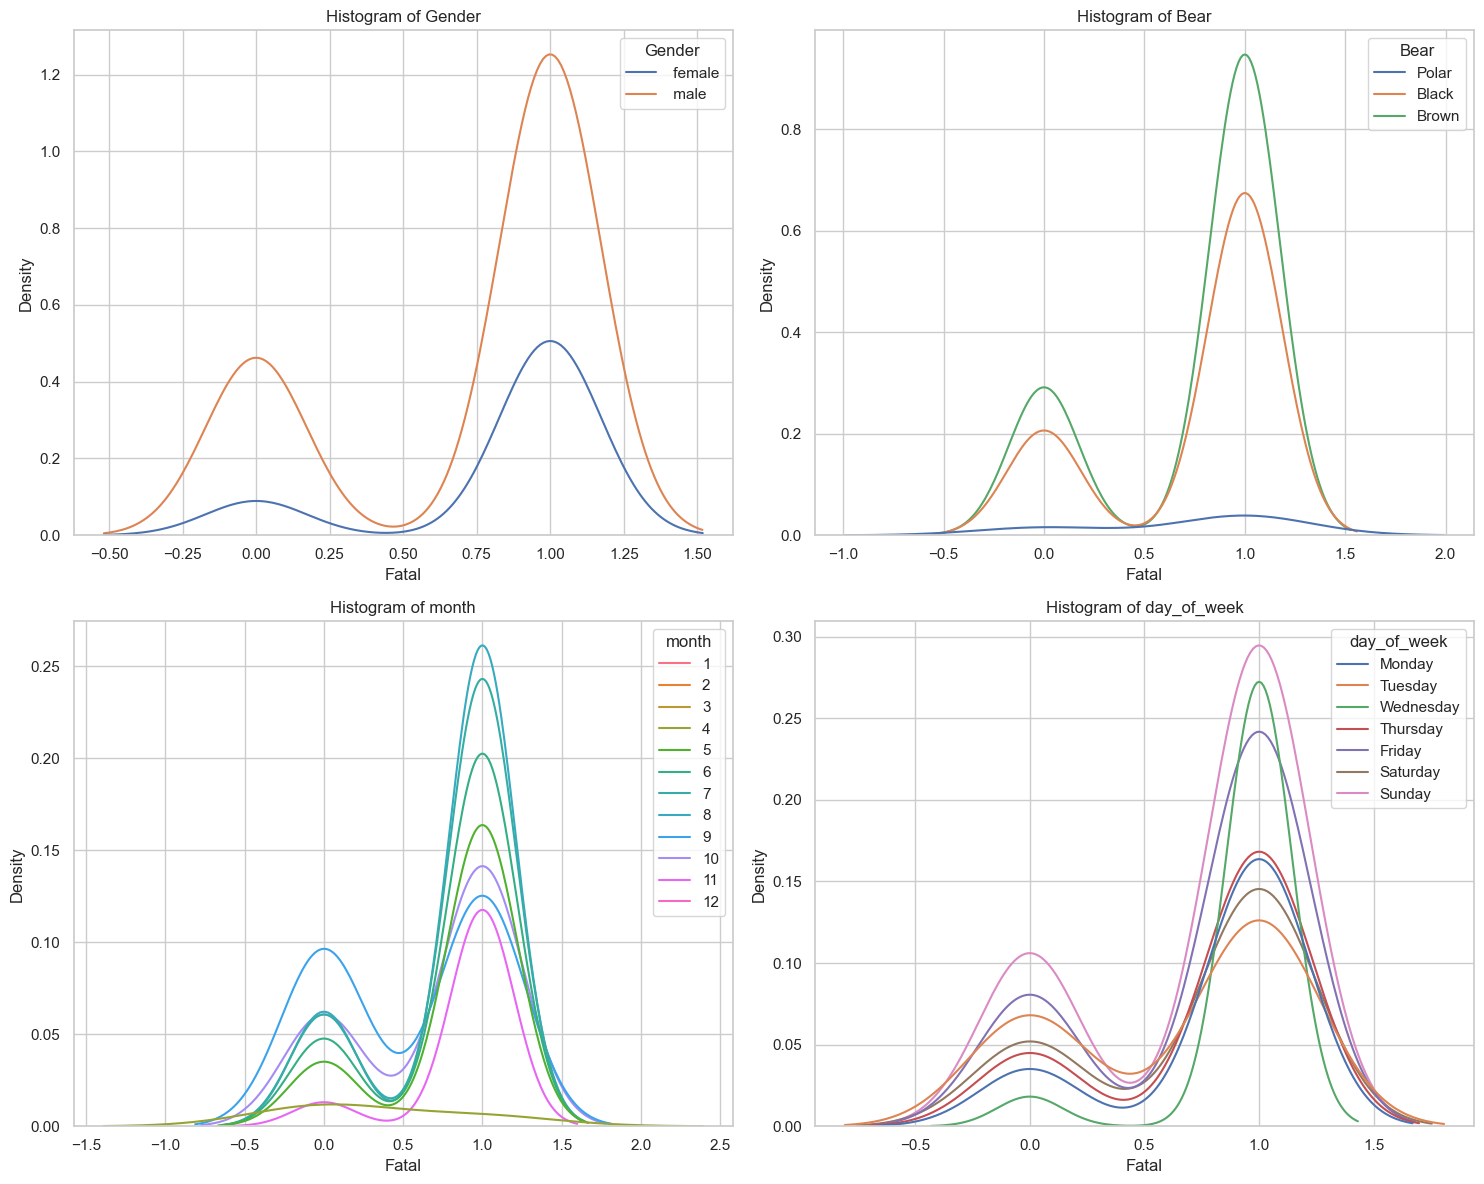

In [199]:
plt.clf()
columns = ['Gender' , 'Bear' , "month" , "day_of_week" ]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))


axes = axes.flatten()


for i, column in enumerate(columns):
    sns.kdeplot(x='Fatal' , data=df , ax=axes[i] , hue = column )
    axes[i].set_title(f"Histogram of {column}")


plt.tight_layout()
plt.show()

In [200]:
def convert_age(age):
    if pd.isna(age) or age == '':  # Handle NaN
        return math.nan
    if isinstance(age, str):
        age = age.strip()  # Remove leading/trailing whitespace
        # Handle months
        if 'months' in age:
            months = int(age.split()[0])
            return months / 12
            
        # Remove non-numeric characters like quotes, and try converting to float
        age = ''.join(filter(str.isdigit, age))
        if age:
            return float(age)
    return age # If it's already a number, return it as is

# Reapply the function to clean and convert the 'Age' column
df['Age'] = df['Age'].apply(convert_age)

# Checking the unique values in the Age column to ensure the conversion was successful
df['Age'].unique()


array([33.0, 31.0, 64.0, 28.0, 46.0, 18.0, 19.0, 62.0, 27.0, 16.0, 22.0,
       36.0, 61.0, 72.0, 74.0, 70.0, 11.0, 6.0, 30.0, 69.0, 71.0, 77.0,
       0.4166666666666667, 93.0, 24.0, 50.0, 56.0, 37.0, 53.0, 4.0, 20.0,
       32.0, 48.0, 12.0, 55.0, 26.0, 44.0, 10.0, 15.0, 51.0, 7.0, 3.0,
       5.0, 52.0, '', 82.0, 8.0, 0.8333333333333334, 38.0, 63.0, 42.0,
       54.0, 49.0, 59.0, 57.0, 60.0, 58.0, 35.0, 41.0, 65.0, 40.0, 45.0,
       29.0, 25.0, 23.0, nan, 43.0, 68.0], dtype=object)

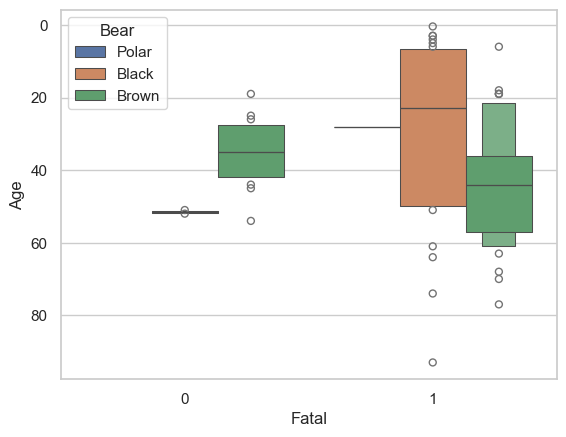

In [237]:
plt.clf()
df['Fatal'] = pd.Categorical(df['Fatal'] , ordered=True)
sns.boxenplot(data = df  ,  x = 'Fatal', y = 'Age' , hue = 'Bear' )
plt.show()

df['Fatal'] = pd.to_numeric(df['Fatal'])

In [208]:
df = df.dropna()
X = pd.get_dummies(df[['Bear']])
y = df['Fatal']
X_train , X_test , y_train , y_test = train_test_split(X , y, train_size=0.80 )
X_train , X_val, y_train , y_val = train_test_split(X_train , y_train , train_size= 0.875 )

base_model = LogisticRegression(random_state= 42)
base_model.fit(X_train , y_train)


base_model.coef_

array([[ 0.54173225, -0.54290698,  0.        ]])

In [209]:
base_model.score(X_val, y_val)

0.8888888888888888

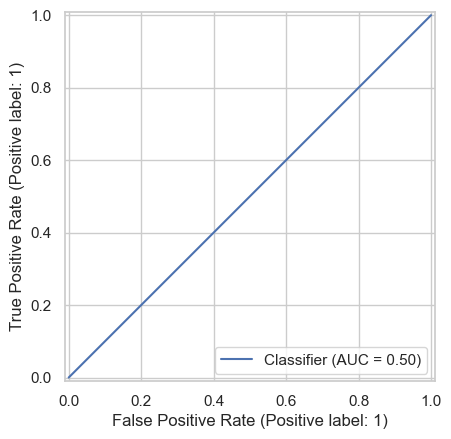

In [221]:
from sklearn.metrics import RocCurveDisplay
y_val_pred = base_model.predict(X_val)
RocCurveDisplay.from_predictions(y_val, y_val_pred)


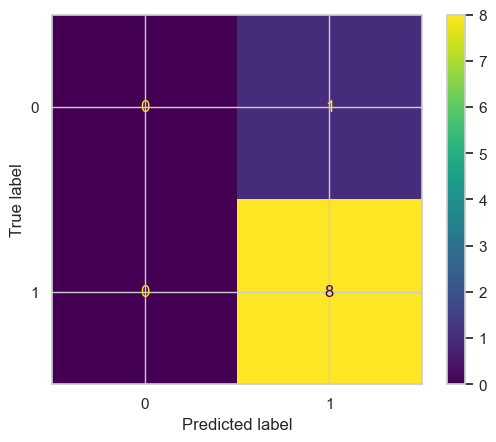

In [211]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_val , y_val_pred)

In [206]:
df.Fatal.value_counts() / len(df)

Fatal
1    0.831325
0    0.168675
Name: count, dtype: float64

In [229]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
cs = list(range(1 , 11 , 1))
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']

skf = StratifiedKFold(n_splits = 5 , shuffle = True , random_state= 42)
logit_cv = LogisticRegressionCV(Cs = cs , cv = skf , penalty = 'l2' , scoring = 'f1')
logit_cv.fit(X_train , y_train)
logit_cv.coef_

array([[ 0.30381841, -0.42422496,  0.12384696]])

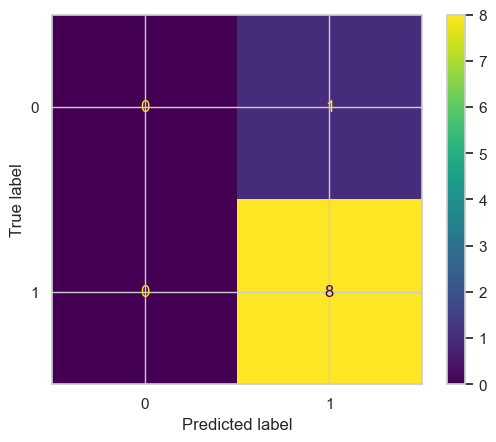

In [230]:
ConfusionMatrixDisplay.from_estimator(logit_cv , X_val , y_val)

In [233]:
y_train.value_counts()

Fatal
1    56
0    11
Name: count, dtype: int64